In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely import geometry
from quetzal.model import stepmodel
from syspy.skims import skims

# Preparation of the LoS tables
## Validates rail service connections
## Needs PT LoS table

In [3]:
input_path = '../input_static/level_of_service/'
output_path = '../output/' + scenario + '/'
model_path = '../model/'

In [4]:
sm = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_pt_los')

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


In [16]:
ln = stepmodel.read_json(model_path + scenario + '/' + 'de_pt_network_agg')
sm.zones = ln.zones

In [6]:
# Generate a price column in the PT LoS table
sm.pt_los['price'] = sm.pt_los[[col for col in sm.pt_los.columns if col[-5:]=='price']].mean(axis=1)

## Prepare the validation data
It had been fetched manually from the DB website beginning of January 2021, searching for trips two weeks ahead during early daytime.

In [7]:
val = pd.read_excel(input_path + 'validation_rail.xls', header=None, engine='xlrd')
val.columns = ['city', 'time', 'duration', 'ntransfers', 'services', 'cost_spar', 'cost_flex']

In [8]:
# Get the names right
val['city'] = val['city'].replace({'Hauptbahnhof, Bonn': 'Bonn'}).str.split(' ')
val['city'] = [l[0].split('(')[0] for l in list(val['city'])]

In [9]:
# Get origin and destination
d = [val.iloc[i, 0] for i in range(1, len(val), 2)]
val = val.iloc[::2, :].rename(columns={'city': 'o'})
val['d'] = d

In [10]:
# Get the times right
val.drop('time', axis=1, inplace=True)
val['duration'] = val['duration'].astype(str).str.split(':')
val['duration'] = [int(l[0]) + float(l[1])/60 for l in list(val['duration'])]

In [11]:
# Get the prices right
for col in ['cost_spar', 'cost_flex']:
    val[col] = [l[0] for l in list(val[col].str.split(','))]
    val[col] = val[col].astype(float)

In [31]:
# replace unknown train stops with zone names
val['o'].replace({'Kassel-Wilhelmshöhe': 'Kassel', 'Zimmersrode': 'Neuental'}, inplace=True)
val['d'].replace({'Kassel-Wilhelmshöhe': 'Kassel', 'Zimmersrode': 'Neuental'}, inplace=True)

In [12]:
val.head(4)

,o,duration,ntransfers,services,cost_spar,cost_flex,d
0,Hamburg,2.050000,0.0,ICE,29.0,75.0,Berlin
2,Hamburg,1.750000,0.0,ICE,29.0,75.0,Berlin
4,Köln,4.366667,0.0,ICE,29.0,114.0,Berlin
6,Köln,4.433333,0.0,ICE,39.0,114.0,Berlin


In [32]:
# Length of zones with matching name
val_stops = set(list(val[['o', 'd']].stack()))
print('Total number of validation stops: {}'.format(len(val_stops)))
print('Missing stops in model zone names: {}'.format(
    val_stops - set(sm.zones['name'])))

Total number of validation stops: 34
Missing stops in model zone names: {'Freiburg', 'Leer', 'Kelkheim', 'Frankfurt', 'Halle'}


In [34]:
# Map names
def get_stop(name):
    for stop in val_stops:
        if stop in name:
            return stop
    return 'nan'
sm.zones['stop'] = sm.zones['name'].apply(lambda name: get_stop(name))
zone_dict = sm.zones.set_index('stop')['FID'].to_dict()
print('Still missing stops in model zone names: {}'.format(
    val_stops - set(sm.zones['stop'])))

Still missing stops in model zone names: set()


In [35]:
assert val_stops-set(zone_dict.keys()) == set()

In [36]:
# Map names to IDs
val['o_nuts'] = val['o'].map(zone_dict)
val['d_nuts'] = val['d'].map(zone_dict)

In [37]:
# Get the distance as the crow flies
sm.zones = gpd.GeoDataFrame(sm.zones)
centroids = sm.zones.centroid
val['distance'] = skims.distance_from_geometry(pd.Series(
    [geometry.LineString([centroids.loc[od[0]], centroids.loc[od[1]]])
     for od in val[['o_nuts', 'd_nuts']].values])) / 1000

In [38]:
# Merge
val = val.merge(sm.pt_los[
    ['origin', 'destination', 'length', 'time', 'price', 'ntransfers', 'link_path', 'route_type', 'route_types', 'in_vehicle_time']
].loc[sm.pt_los['route_type'].str.startswith('rail')], #.isin(['rail_long', 'rail_short', 'bus', 'coach', 'rail'])]
                how='left', left_on=['o_nuts', 'd_nuts'], right_on=['origin', 'destination'])
val.head(2)

,o,duration,ntransfers_x,services,cost_spar,cost_flex,d,o_nuts,d_nuts,distance,origin,destination,length,time,price,ntransfers_y,link_path,route_type,route_types,in_vehicle_time
0,Hamburg,2.05,0.0,ICE,29.0,75.0,Berlin,20000000,120670440,273.871978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hamburg,1.75,0.0,ICE,29.0,75.0,Berlin,20000000,120670440,493.969563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# All connections should exist in the model
val.loc[val['link_path'].isna()]

,o,duration,ntransfers_x,services,cost_spar,cost_flex,d,o_nuts,d_nuts,distance,origin,destination,length,time,price,ntransfers_y,link_path,route_type,route_types,in_vehicle_time
0,Hamburg,2.050000,0.0,ICE,29.0,75.0,Berlin,20000000,120670440,273.871978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hamburg,1.750000,0.0,ICE,29.0,75.0,Berlin,20000000,120670440,493.969563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Köln,4.366667,0.0,ICE,29.0,114.0,Berlin,53150000,120670440,493.969563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Köln,4.433333,0.0,ICE,39.0,114.0,Berlin,53150000,120670440,650.912919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Köln,4.366667,0.0,ICE,67.0,114.0,Berlin,53150000,120670440,219.725654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Freiburg,6.483333,2.0,ICE,79.0,139.0,Berlin,83110000,120670440,318.885528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Freiburg,6.550000,1.0,ICE,79.0,139.0,Berlin,83110000,120670440,312.597580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Freiburg,6.500000,0.0,ICE,47.0,139.0,Berlin,83110000,120670440,312.597580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,München,4.500000,0.0,ICE,35.0,139.0,Berlin,160765006,120670440,191.802132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Kassel,2.816667,1.0,ICE,29.0,90.0,Berlin,66110000,120670440,191.802132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
lines = [geometry.LineString([ln.links.loc[i, 'geometry'].coords[0] for i in l]
                             + [ln.links.loc[l[-1], 'geometry'].coords[-1]])
         for l in list(val.loc[val['link_path'].notna(), 'link_path'])]
gdf = gpd.GeoDataFrame(data={'ind': range(len(lines))}, geometry=lines)
cmap = cm.get_cmap('gist_rainbow')

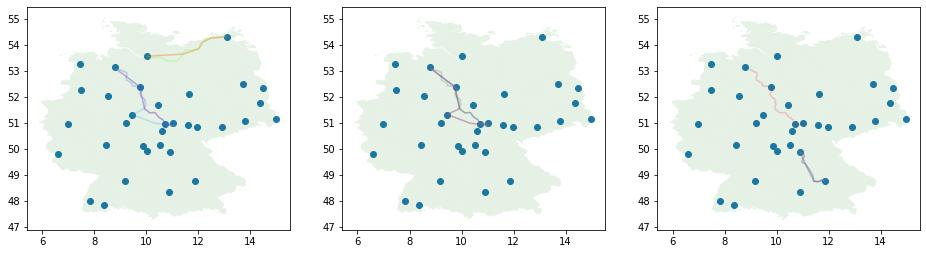

In [42]:
nplots = 3
cut = int(len(gdf)/nplots)
fix, axes = plt.subplots(nrows=1, ncols=nplots, figsize=(16,16))
for i in range(nplots):
    gdf.iloc[i*cut:(i+1)*cut].plot(cmap=cmap, alpha=.2, ax=sm.zones.plot(
        color='g', alpha=.1, ax=centroids.loc[list(set(val[['o_nuts', 'd_nuts']].stack()))].plot(ax=axes[i])))

In [23]:
gdf['route_type'] = list(val.loc[val['link_path'].notna(), 'route_type'])
gdf.to_file(output_path + 'validation_rail.geojson', driver='GeoJSON')

# Validate connection data

In [38]:
def get_trend(x, y, label):
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker=' ', label=label)
    plt.scatter(x, y, marker='o', alpha=.2, label=label)
    print('{}: y={}*x+{}'.format(label, np.round(z[0], 3), np.round(z[1], 3)))

## Distance
Comparing as-the-crow-flies air distance and length of the model paths

In [39]:
# Convert to km
val['length'] = val['length'] / 1000

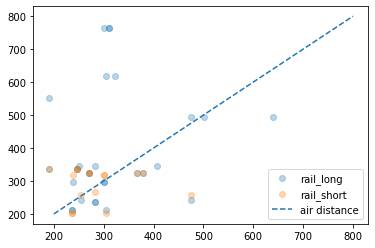

In [40]:
# X-axis is the direct distance between centroids
# Y-axis is the length of the corresponding route
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['length'],
                marker='o', alpha=.3, label=t)
plt.plot([200,800], [200,800], linestyle='--', marker='', label='air distance')
plt.legend()

## Time
The PT graph should hold reasonable connections for the rail mode. Coach services are uncritical because they were not aggregated and persist as they come from GTFS feeds. Rail connections on the other hand relie on long- and short-distance trips which are algorithmically connected and aggregated.

In [41]:
# Convert to hours
val['time'] = val['time'] / 3600 if val['time'].mean()>3600 else val['time']
val['in_vehicle_time'] = val['in_vehicle_time'] / 3600

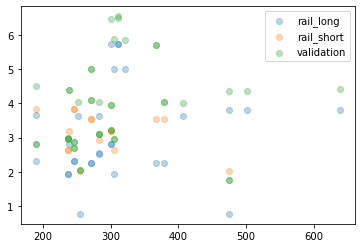

In [42]:
# Compare in-vehicle time
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['in_vehicle_time'],
                marker='o', alpha=.3, label=t)
plt.scatter(val['distance'], val['duration'], marker='o', alpha=.3, label='validation')
plt.legend()

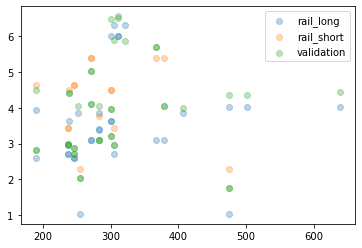

In [43]:
# Whole-path time
for t in ['rail_long', 'rail_short']:
    plt.scatter(val.loc[val['route_type']==t]['distance'],
                val.loc[val['route_type']==t]['time'],
                marker='o', alpha=.3, label=t)
plt.scatter(val['distance'], val['duration'], marker='o', alpha=.3, label='validation')
plt.legend()

rail_long: y=0.824*x+-0.258
rail_short: y=0.245*x+2.441


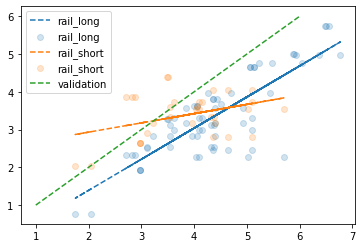

In [44]:
# In-vehicle time
for t in ['rail_long', 'rail_short']:
    x = val.loc[val['route_type']==t]['duration']
    y = val.loc[val['route_type']==t]['in_vehicle_time']
    get_trend(x, y, t)
plt.plot([1,6], [1,6], linestyle='--', marker='', label='validation')
plt.legend()

rail_long: y=0.93*x+0.062
rail_short: y=0.583*x+2.268


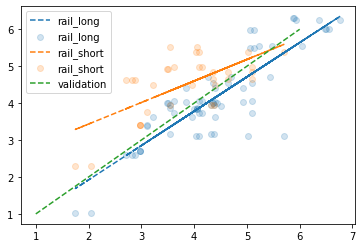

In [45]:
# Now for whole-path time
for t in ['rail_long', 'rail_short']:
    x = val.loc[val['route_type']==t]['duration']
    y = val.loc[val['route_type']==t]['time']
    get_trend(x, y, t)
plt.plot([1,6], [1,6], linestyle='--', marker='', label='validation')
plt.legend()

## Prices
In long-distance rail transport, there are "Sparpreise" which divert from regular distance-based price generation

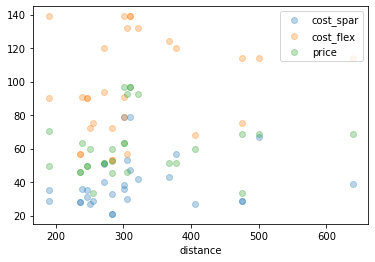

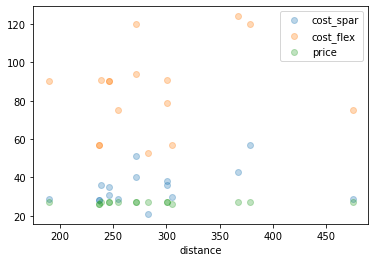

In [46]:
for t in ['rail_long', 'rail_short']:
    val.loc[val['route_type']==t][['cost_spar', 'cost_flex', 'price', 'distance']
                                 ].set_index('distance').plot(linestyle=' ', marker='o', alpha=.3)

In [47]:
sm.pt_los['length'] = sm.pt_los['length'] / 1000

rail_long: y=0.117*x+22.693
rail_short: y=0.061*x+10.935
Sparpreis: y=0.059*x+17.412
Flexpreis: y=0.149*x+35.263


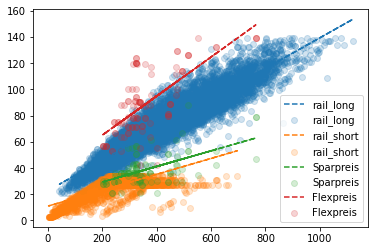

In [48]:
for t in ['rail_long', 'rail_short']:
    sample = sm.pt_los.loc[sm.pt_los['route_type']==t].sample(10000)
    try:
        get_trend(sample['length'], sample['price'], t)
    except:
        plt.scatter(sample['length'], sample['price'], marker='o', alpha=.2, label=t)
get_trend(val['length'], val['cost_spar'], 'Sparpreis')
get_trend(val['length'], val['cost_flex'], 'Flexpreis')
plt.legend()

In [49]:
# Perform a regression analysis to find the distance-duration (explainatory variables)
# dependency of prices (dependent variable)
sample = val.drop_duplicates(['o', 'd', 'duration'])
X = sample[['duration', 'length']].values # in hours, km
# Differentiate by price types
for price in ['cost_spar', 'cost_flex']:
    Y = sample[price].values
    model = LinearRegression().fit(X, Y)
    r_sq = model.score(X, Y)
    print(price)
    print('Coefficient of determination (R²): ', r_sq)
    print('Intercept:', model.intercept_)
    print('Slopes:', model.coef_)

cost_spar
Coefficient of determination (R²):  0.4550882791835512
Intercept: 5.310950989889463
Slopes: [5.61491099 0.02474774]
cost_flex
Coefficient of determination (R²):  0.5591111827201973
Intercept: 24.71749850815047
Slopes: [5.77466835 0.10943986]


In [35]:
# Save the merged validation table
writer = pd.ExcelWriter(output_path + 'validation_rail_merged.xlsx', engine='xlsxwriter')
val.to_excel(writer)
writer.save()